# Practice #2. "Trend predictive models"

This notebook is dedicated to:
* Forecasting Performance Measures
* Naive Approach
* Simple Exponential Smoothing
* Holt's Linear Trend Model
* Holt Winter's Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

## 0. Data reading and visualization

Please, specify path to data

In [20]:
path_to_datafile = "../data/airline-passengers.csv"

In [21]:
# data reading to pandas.DataFrame
df = pd.read_csv(path_to_datafile)

Please, rename time column to `ds` and data column to `y`(you can use `df.rename`) . If use dataset with multiple features select only one and drop NaN values

In [22]:
# your code here
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

Convert date column to datetime format and set as index

In [23]:
df["ds"] = pd.to_datetime(df["ds"])
df.set_index("ds", inplace=True)

Number of data data points:

In [24]:
df.shape[0]

144

Print slice of the timeseries:

In [25]:
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Split the data on train and test set. Test set - last 15 % of the dataset. We'll use a training test for model training and a test set for accuracy measuring.

In [100]:
# your code here
split = int((1 - 0.15) * df.shape[0])
df_train = df[:split]
df_test = df[split:]

Let's plot the data

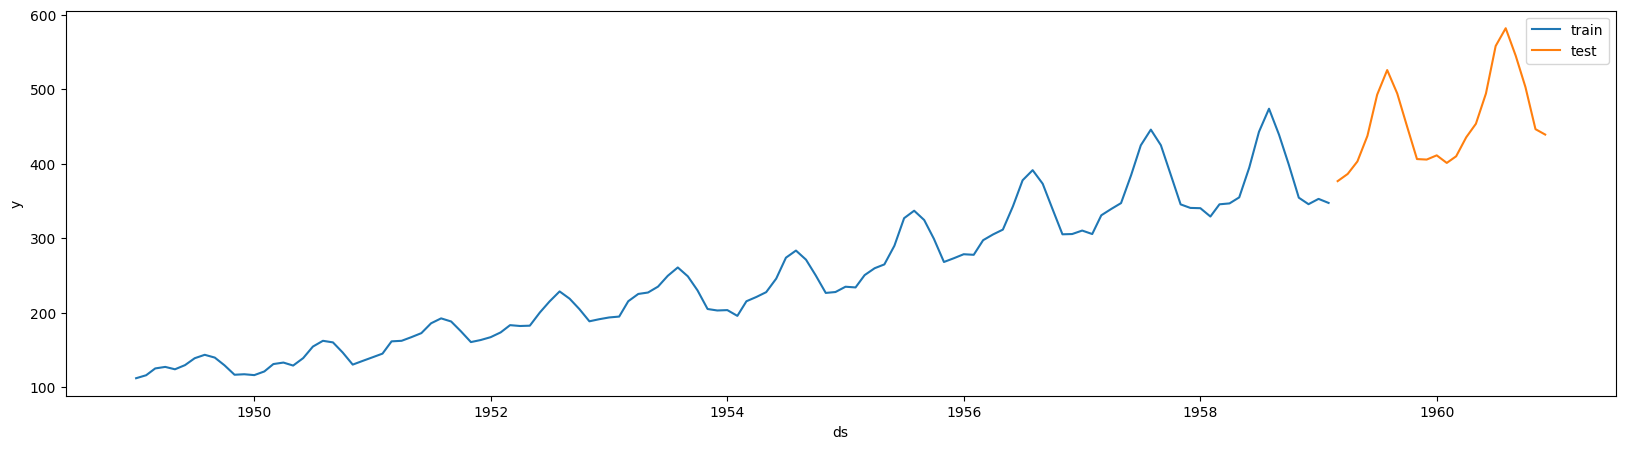

In [101]:
plt.figure(figsize=(20, 5))
plt.ylabel("y")
plt.xlabel("ds")
plt.plot(df_train, label="train")
plt.plot(df_test, label="test")
plt.legend();

Please, smooth selected time series

In [103]:
# your code here
df_train = df_train.ewm(alpha=0.5).mean()
df_test = df_test.ewm(alpha=0.5).mean()

## 1. Forecasting Performance Measures

In [33]:
x = [0.5, 0.5, 0.5, 0.5]
x_hat = [0.7, 0.5, 0.3, 0.2]

### 1.1 Forecast Error(Residual Forecast Error)

The forecast error is calculated as the expected value minus the predicted value. This is called the residual error of the prediction.<br><br>

$$
    Error = x - \widehat{x}
$$
$x$ - ground truth target values<br>
$\widehat{x}$ - estimated target values<br><br>

The forecast error can be calculated for each prediction, providing a time series of forecast errors.  Could be useful for estimate dynamic and nature of error.<br>
Example:

In [13]:
error = np.subtract(x, x_hat)
error

array([-0.2,  0. ,  0.2,  0.3])

### 1.2 Mean Forecast Error(Forecast Bias)

Mean forecast error is calculated as the average of the forecast error values.<br><br>

$$
Error = \frac{\sum_{i=1}^{n} x_i - \widehat{x}_i}{n}
$$
$x$ - ground truth target values<br>
$\widehat{x}$ - estimated target values<br>
$n$ - number of points in the target values vector<br><br>

Forecast errors can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero. A mean forecast error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error). As such, the mean forecast error is also called the forecast bias. The forecast error can be calculated directly as the mean of the forecast values.<br>
Example:

In [4]:
error = np.mean(np.subtract(x, x_hat))
error

0.07500000000000001

### 1.3 Mean Absolute Error

The mean absolute error(MAE) is calculated as the average of the forecast error values, where all of the forecast values are forced to be positive.<br><br>

$$
MAE = \frac{\sum_{i=1}^{n} |x_i - \widehat{x}_i|}{n}
$$
$x$ - ground truth target values<br>
$\widehat{x}$ - estimated target values<br>
$n$ - number of points in the target values vector<br><br>

The mean absolute error is a common measure of forecast error in time series analysis,[3] sometimes used in confusion with the more standard definition of mean absolute deviation.<br>
Example:

In [5]:
MAE = mean_absolute_error(x, x_hat)
MAE

0.175

### 1.4 Mean Squared Error

The mean squared error(MSE) is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive; it also has the effect of putting more weight on large errors. Very large or outlier forecast errors are squared, which in turn has the effect of dragging the mean of the squared forecast errors out resulting in a larger mean squared error score. In effect, the score gives worse performance to those models that make large wrong forecasts.<br><br>

$$
MSE = \frac{\sum_{i=1}^{n} (x_i - \widehat{x}_i)^2}{n}
$$
$x$ - ground truth target values<br>
$\widehat{x}$ - estimated target values<br>
$n$ - number of points in the target values vector<br><br>

Example:

In [6]:
RMSE = mean_squared_error(x, x_hat)
RMSE

0.042499999999999996

### 1.5 Root Mean Squared Error

The mean squared error(RMSE) is in the squared units of the predictions. It can be transformed back into the original units of the predictions by taking the square root of the mean squared error score.<br><br>

$$
RMSE = \sqrt{\frac{\sum_{i=1}^{n} (x_i - \widehat{x}_i)^2}{n}}
$$
$x$ - ground truth target values<br>
$\widehat{x}$ - estimated target values<br>
$n$ - number of points in the target values vector<br><br>

Example:

In [7]:
RMSE = np.sqrt(mean_squared_error(x, x_hat))
RMSE

0.206155281280883

In examples belowe we'll use RMSE.

## 2. Naive Approach

### 2.1 Naive Approach

Let's take the simple naive that in  future values of time series will be near the last known value.

In [104]:
# your code here
n_train = df_train.shape[0]
df_forecast = df_test.copy()
df_forecast.y[0] = int(np.random.normal(df_train.y[n_train-1], scale=10, size=1))
for i in range(1, df_forecast.shape[0]):
    df_forecast.y[i] = int(np.random.normal(df_forecast.y[i-1], scale=10, size=1))

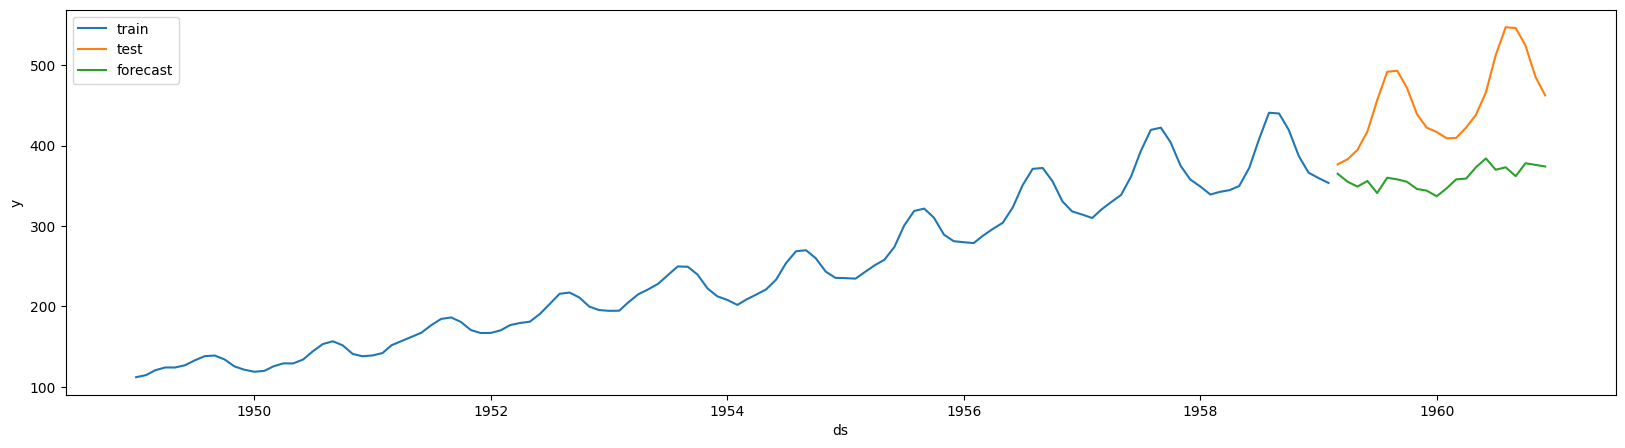

In [105]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(df_forecast, label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Naive approach's error

In [106]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast['y']))

np.float64(103.96889910915726)

### 2.2 Moving average

In the previous practice we've used a moving average for time-series smoothing. Also, this method could be used for forecasting. A forecast point calculates as an average of $N$ previous points, where $N$ - window size.

Please, calculate  prediciton using trailing moving average.

In [109]:
# your code here
n = 21
df_forecast = df_train.copy()
for i in range(df_test.shape[0]):
    date = df_test.index[i]
    value = df_forecast.rolling(window=n).mean()
    add = pd.DataFrame([
        {"ds": date,
         "y": value.iloc[-1].y
         }
    ])
    add.set_index("ds", inplace=True)
    df_forecast = pd.concat([df_forecast, add])

df_forecast = df_forecast[df_train.shape[0]:]

 Smoothed data visualization and comparision

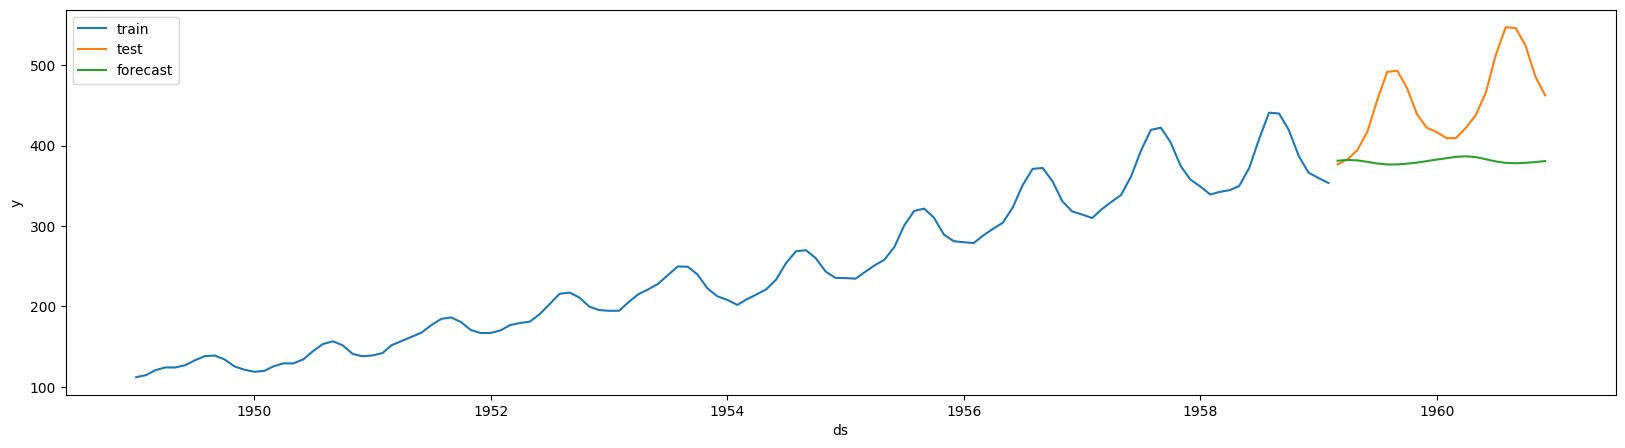

In [110]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(df_forecast, label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Moving average's error

In [111]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast['y']))

np.float64(89.32030083447631)

Please, make prediction using different window sizes and compare results. Select the optimal windows size.

In [112]:
# your code here
best_i = -1
best_mse = 1e9
for window_size in range(1, 100):
    df_forecast = df_train.copy()
    for i in range(df_test.shape[0]):
        date = df_test.index[i]
        value = df_forecast.rolling(window=window_size).mean()
        add = pd.DataFrame([
            {"ds": date,
             "y": value.iloc[-1].y
             }
        ])
        add.set_index("ds", inplace=True)
        df_forecast = pd.concat([df_forecast, add])
    
    df_forecast = df_forecast[df_train.shape[0]:]
    mse = np.sqrt(mean_squared_error(df_test['y'], df_forecast['y']))
    if mse < best_mse:
        best_i, best_mse = i, mse
print(best_mse, i)

84.05094161123347 21


### 2.3 Linear regression

Another naive aproach to forecas is the Linear Regression model.<br>
Please, make forecast using Linear Regression method.

In [113]:
# your code here
model = LinearRegression()
x = np.arange(len(df_train.index)).reshape(-1, 1)
model.fit(x, df_train.y)
x_test = (x[-1] + np.arange(0, len(df_test.index))).reshape(-1, 1)
df_forecast = pd.DataFrame({"y": model.predict(x_test)})
df_forecast.index = df_test.index

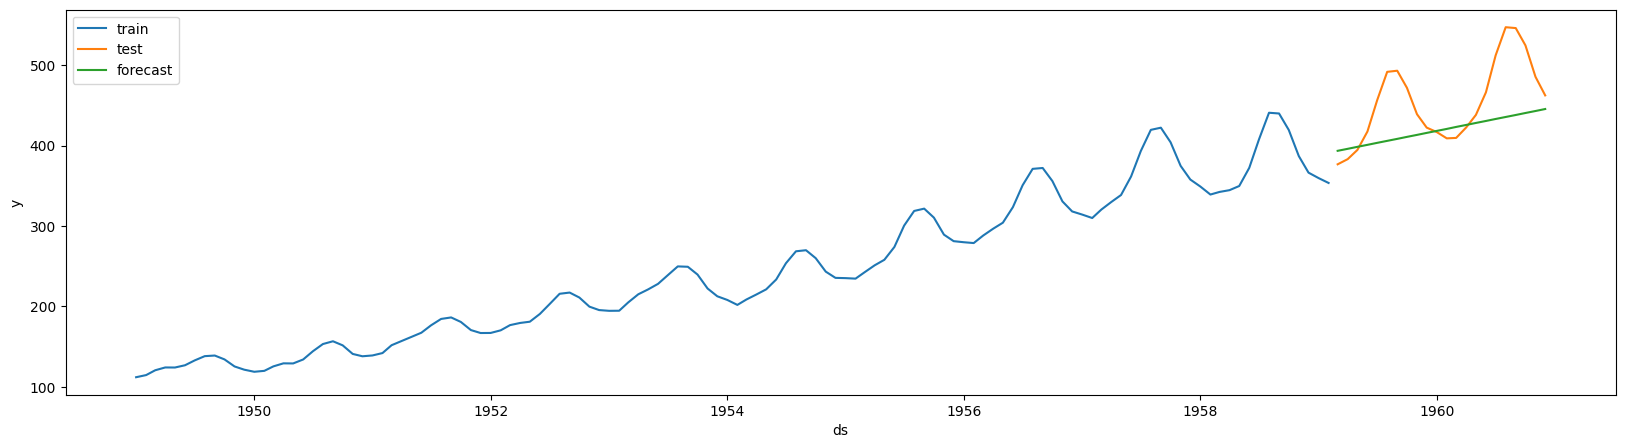

In [114]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(df_forecast, label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Linear regression's error

In [115]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast['y']))

np.float64(53.84123746743469)

Be careful with Linear Regression, because in the current simplest approach LR uses the only datetime as a feature and extrapolates values outside of the training domain. Such predictions are often not accurate.

![title](https://hsto.org/webt/jp/s8/rp/jps8rp9ee-v4hvobowhm6lq7vfa.jpeg)

## 3. Simple Exponential Smoothing

`statsmodels.tsa.holtwinters.ExponentialSmoothing`class not only smooth time series, but also forecast.<br>
The class provides standart model interface: `fit` and `predict` methods.

Please, calculate exponential smoothing.

In [165]:
# your code here
model = ExponentialSmoothing(
    df_train.y,
    trend=None,
    seasonal=None,
    seasonal_periods=2
)
fitted_model = model.fit()

df_forecast = pd.DataFrame(fitted_model.forecast(df_test.shape[0]))
df_forecast.index = df_test.index

Results of the both methods shold be identical 

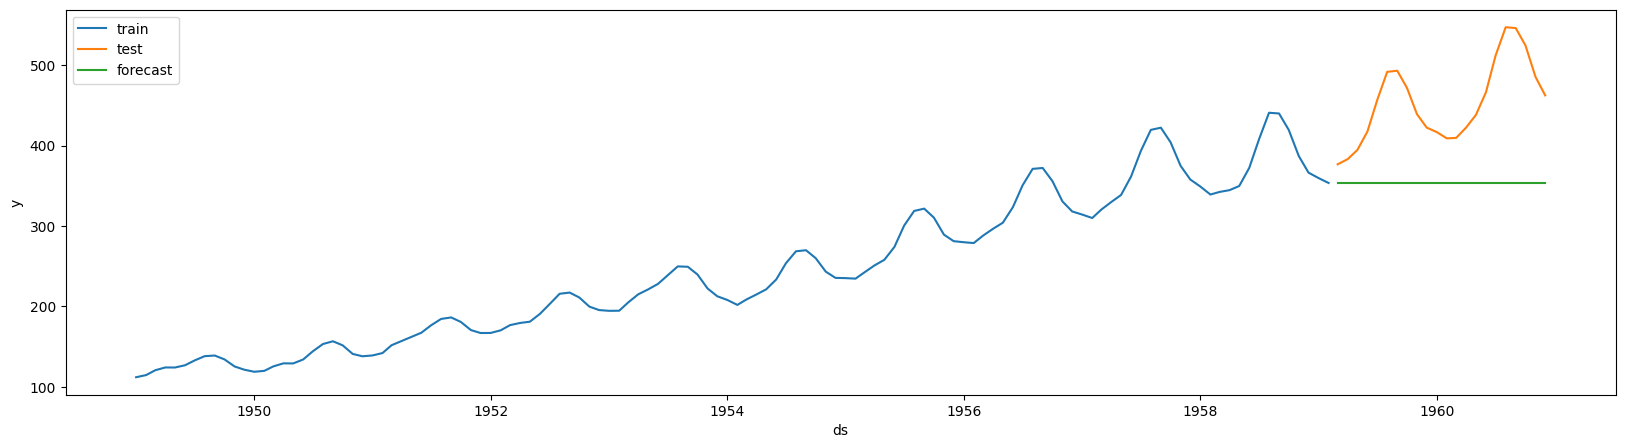

In [166]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(df_forecast, label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Simple Exponential Smoothing's error

In [167]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast))

np.float64(111.90566174377221)

Please, select the optimal model's parameter to reduce MSE

In [168]:
# your code here
best_mse = 1e9
best_i = -1
for season in range(2, 36):
    model = ExponentialSmoothing(
        df_train.y,
        trend=None,
        seasonal=None,
        seasonal_periods=season
    )
    fitted_model = model.fit(optimized=True)
    
    df_forecast = pd.DataFrame(fitted_model.forecast(df_test.shape[0]))
    df_forecast.index = df_test.index
    
    mse = np.sqrt(mean_squared_error(df_test['y'], df_forecast))
    if mse < best_mse:
        best_i, best_mse = season, mse

print(best_mse, best_i)

111.90566174377221 2


## 4. Holt's Linear Trend Model

Please use `statsmodels.tsa.holtwinters.ExponentialSmoothing` to forecast time series using double exponential smoothing.

In [169]:
# your code here
# your code here
model = ExponentialSmoothing(
    df_train.y,
    trend='add',
    seasonal=None,
    seasonal_periods=2
)
fitted_model = model.fit()

df_forecast = pd.DataFrame(fitted_model.forecast(df_test.shape[0]))
df_forecast.index = df_test.index

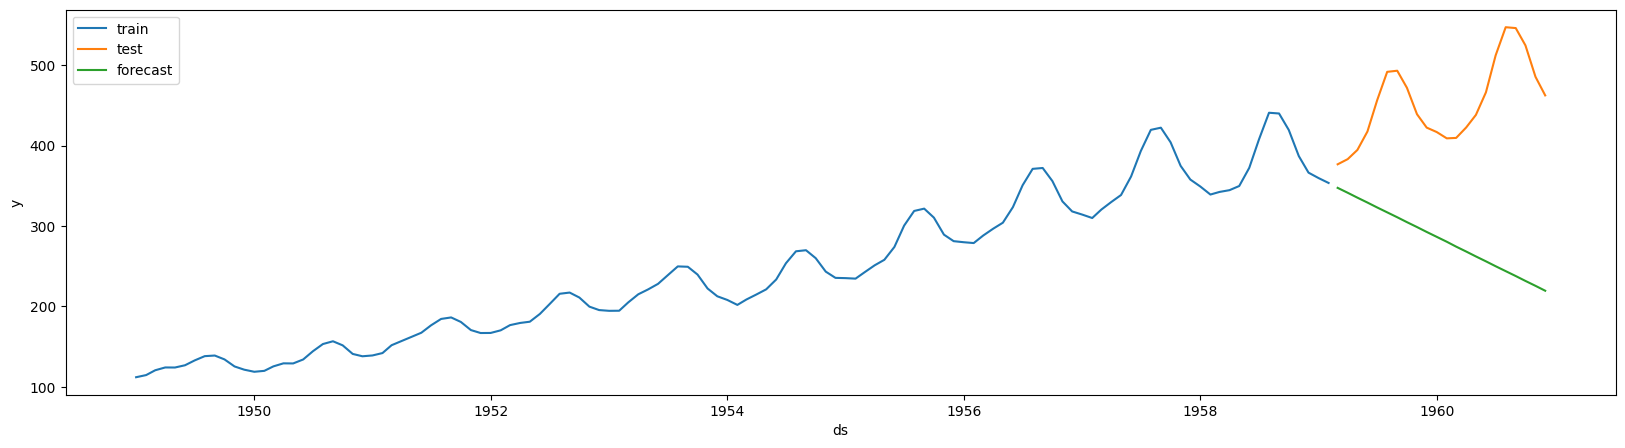

In [170]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(df_forecast, label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

 Holt's Linear Trend Model's RMSE

In [171]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast))

np.float64(188.13123362929926)

Please, select the optimal model's parameters and trend type to reduce MSE

In [172]:
# your code here
best_mse = 1e9
best_i = -1
for season in range(2, 36):
    model = ExponentialSmoothing(
        df_train.y,
        trend='add',
        seasonal=None,
        seasonal_periods=season
    )
    fitted_model = model.fit(optimized=True)
    
    df_forecast = pd.DataFrame(fitted_model.forecast(df_test.shape[0]))
    df_forecast.index = df_test.index
    
    mse = np.sqrt(mean_squared_error(df_test['y'], df_forecast))
    if mse < best_mse:
        best_i, best_mse = season, mse

print(best_mse, best_i)

188.13123362929926 2


## 5. Holt Winter's Model

Please, make forecast using triple exponential smoothing.

In [179]:
# your code here
model = ExponentialSmoothing(
    df_train.y,
    trend='add',
    seasonal='add',
    seasonal_periods=25
)
fitted_model = model.fit()

df_forecast = pd.DataFrame(fitted_model.forecast(df_test.shape[0]))
df_forecast.index = df_test.index

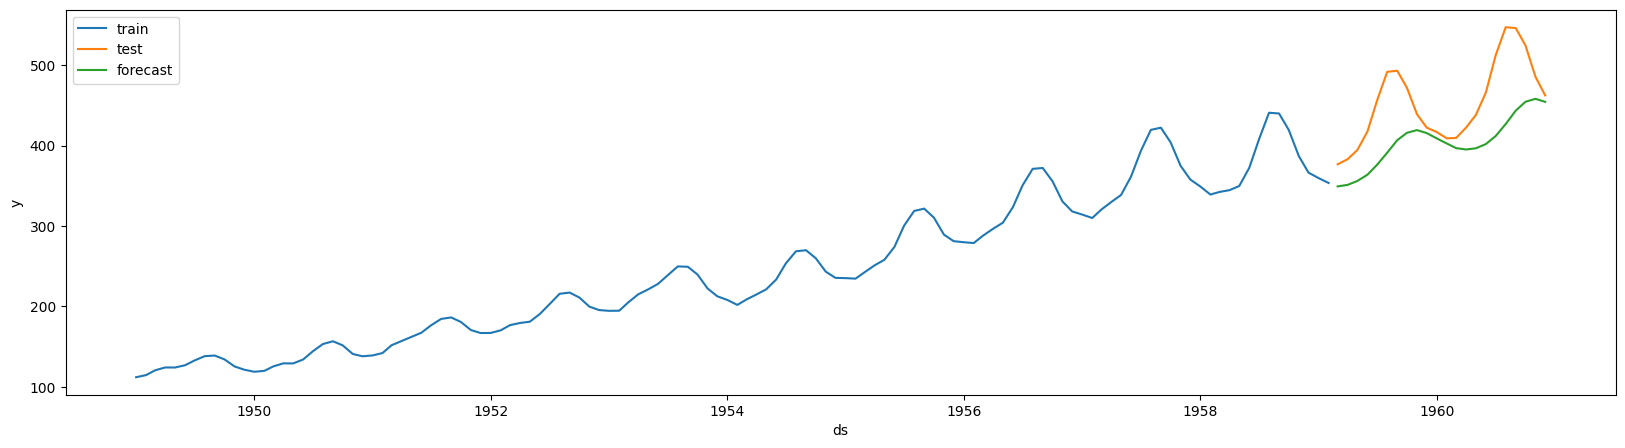

In [180]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(df_forecast, label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Holt Winter's Model's RMSE

In [ ]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast))

Please, select the optimal model's parameter, trend and seasonality types to reduce MSE.

In [182]:
# your code here
best_mse = 1e9
best_i = -1
for season in range(2, 36):
    model = ExponentialSmoothing(
        df_train.y,
        trend='add',
        seasonal='add',
        seasonal_periods=season
    )
    fitted_model = model.fit(optimized=True)
    
    df_forecast = pd.DataFrame(fitted_model.forecast(df_test.shape[0]))
    df_forecast.index = df_test.index
    
    mse = np.sqrt(mean_squared_error(df_test['y'], df_forecast))
    if mse < best_mse:
        best_i, best_mse = season, mse

print(best_mse, best_i)

60.83351543923383 25


Which model has the lowest error?

Triple exponential smoothing is effective because it accounts for seasonality.